<h1> Dhaka air quality </h1>

This project aims to analyse the air quality data for Dhaka city since 2016.

The data is collected from the US Embassy in Dhaka, which records hourly air quality measurements using a monitor on their roof. Their instrument measures the average concentration of fine particle pollutants (PM2.5) in the air over an hour and converts this into an Air Quality Index (AQI) value. AQI is a numerical scale, between 0 and 500, informing how potentially dangerous the air is to health, where small numbers are good and large numbers are bad.

The recognised acceptable standard for AQI is up to 100, once the quality of air degrades to an AQI above 100, sensitive groups of people may experience adverse health effects. AQI values above 150 are considered "unhealthy", meaning everyone begins to be at risk of adverse health issues, the severity of which increases as the AQI gets larger -- with air deemed "very unhealthy" at AQI in excess of 200 and "extremely unhealthy" above 300.

<h2> Analysis and Visualisation </h2>

This notebook imports the cleaned data from the "pre-processing" notebook. Various investiagtions are made, such as time-series analysis looking for seasonal variation and time of day variations, whether statistically the overall air quality situation has changed since 2016, whether Covid-19 lockdowns had any discernable affects, etc.

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from datetime import datetime, timedelta 
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib as mpl

<h2> Data import </h2>

In [2]:
datapath = Path('../data/')
df = pd.read_csv(f'{datapath}/USembassy_dhakadata_clean.csv', parse_dates=['Date (LT)'], index_col='Date (LT)')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36897 entries, 2016-03-01 03:00:00 to 2020-09-19 00:00:00
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Site           36897 non-null  object 
 1   Parameter      36897 non-null  object 
 2   Year           36897 non-null  int64  
 3   Month          36897 non-null  int64  
 4   Day            36897 non-null  int64  
 5   Hour           36897 non-null  int64  
 6   NowCast Conc.  36897 non-null  float64
 7   AQI            36897 non-null  int64  
 8   AQI Category   36897 non-null  object 
 9   Raw Conc.      36897 non-null  float64
 10  Conc. Unit     36897 non-null  object 
 11  Duration       36897 non-null  object 
 12  QC Name        36897 non-null  object 
dtypes: float64(2), int64(5), object(6)
memory usage: 3.9+ MB


In [4]:
df.tail()

,Site,Parameter,Year,Month,Day,Hour,NowCast Conc.,AQI,AQI Category,Raw Conc.,Conc. Unit,Duration,QC Name
Date (LT),,,,,,,,,,,,,
2020-09-18 20:00:00,Dhaka,PM2.5 - Principal,2020,9,18,20,32.0,93,Moderate,35.0,UG/M3,1 Hr,Valid
2020-09-18 21:00:00,Dhaka,PM2.5 - Principal,2020,9,18,21,31.0,91,Moderate,30.0,UG/M3,1 Hr,Valid
2020-09-18 22:00:00,Dhaka,PM2.5 - Principal,2020,9,18,22,28.0,84,Moderate,25.0,UG/M3,1 Hr,Valid
2020-09-18 23:00:00,Dhaka,PM2.5 - Principal,2020,9,18,23,27.9,84,Moderate,28.0,UG/M3,1 Hr,Valid
2020-09-19 00:00:00,Dhaka,PM2.5 - Principal,2020,9,19,0,27.9,84,Moderate,28.0,UG/M3,1 Hr,Valid


<h2>Quick exploration</h2>

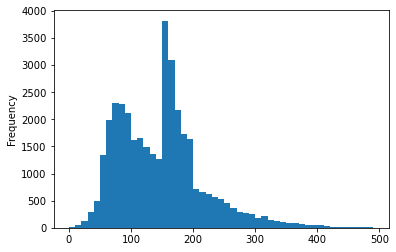

In [5]:
df['AQI'].plot(kind='hist', bins=range(0,500,10))

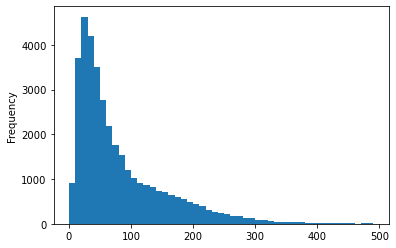

In [6]:
df['Raw Conc.'].plot(kind='hist', bins=range(0,500,10))

In [7]:
df['AQI Category'].value_counts(normalize=True)

Unhealthy                         0.336559
Moderate                          0.274006
Unhealthy for Sensitive Groups    0.198471
Very Unhealthy                    0.127111
Hazardous                         0.035477
Good                              0.028376
Name: AQI Category, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fea3b94ee50>,
      dtype=object)

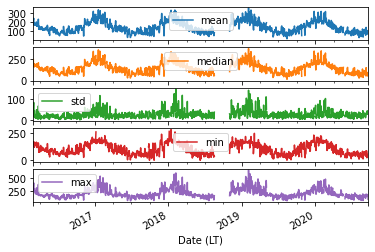

In [8]:
df.AQI.resample('D').agg(['mean', 'median', 'std', 'min', 'max']).plot(subplots=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fea3c664410>,
      dtype=object)

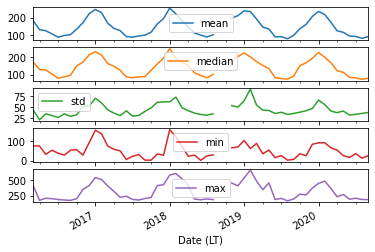

In [9]:
df.AQI.resample('M').agg(['mean', 'median', 'std', 'min', 'max']).plot(subplots=True)

In [10]:
def time_resample(dataframe, time_period):
    '''
    Resamples the dataframe over the given period of time. 
    For example, if values averaged over a day required then arguments would be df and "D"
    
    >> time_period: 'D' = days, 'M' = month, 'Y' = year

    Returns dataframe object
    '''
    resampled_df = pd.DataFrame()
    resampled_df['AQImean'] = dataframe.AQI.resample(time_period).mean()
    resampled_df['AQImed'] = dataframe.AQI.resample(time_period).median()
    resampled_df['AQImin'] = dataframe.AQI.resample(time_period).min()
    resampled_df['AQImax'] = dataframe.AQI.resample(time_period).max()
    resampled_df['AQIstd'] = dataframe.AQI.resample(time_period).std()
    #resampled_df['Date'] = dataframe.Date.resample(time_period).first()
    resampled_df['Month'] = dataframe.Month.resample(time_period).first()
    resampled_df['Year'] = dataframe.Year.resample(time_period).first()
    resampled_df['Day'] = dataframe.Day.resample(time_period).first()
    #  To ensure statistical significance want to omit values when a significant fraction of the
    #  expected number of measurements in the given time period are missing. 
    #  For example, days when only 5 hours in 24 have measurement data available.
    #  Lets exclude data where half the expected measurements missing:
    resampled_df['Measurements'] = dataframe.AQI.resample(time_period).count()
    resampled_df = resampled_df[resampled_df['Measurements']>resampled_df['Measurements'].max()/2]
    return resampled_df

In [11]:
df_dayavg = time_resample(df, 'D')
df_monthavg = time_resample(df, 'M')

Text(0.5, 1.0, 'Distribution of Daily Average AQI')

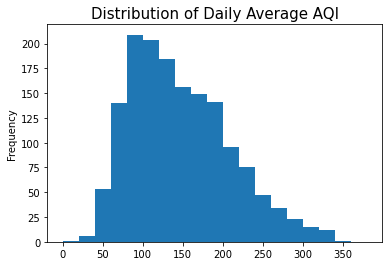

In [12]:
df_dayavg.AQImean.plot(kind='hist', bins=range(0,400,20))
plt.title('Distribution of Daily Average AQI', fontsize=15)

Text(0.5, 1.0, 'Distribution of Monthly Average AQI')

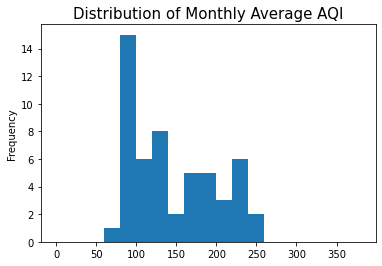

In [13]:
df_monthavg.AQImean.plot(kind='hist', bins=range(0,400,20))
plt.title('Distribution of Monthly Average AQI', fontsize=15)

<h2> AQI Categories Explained </h2>

The AQI is divided in six categories and each category is meant to correspond to different health concern levels. Below is an explanation of the categories and their meanings.

    0 – 50 indicates “Good” AQI. At this level the quality of air is deemed to be satisfactory, and air pollution poses little or no risk.

    51 – 100 indicate “Moderate” AQI. This means acceptable Air quality. However, some pollutants might arouse modest health concern for a limited number of people. For instance, persons who are remarkably sensitive to ozone may experience respiratory symptoms.

    101 – 150 indicate “Unhealthy for Sensitive Groups” AQI. This category may not be able to affect the general health of the public. However, children, older adults, and persons with lung disease are at a greater risk from ozone exposure. Older children, adults and people with lung and heart disease are at greater risk from exposure to particulate matter.

    151 – 200 indicate “Unhealthy” AQI. In this category, every person might experience some adverse health effects. Sensitive group members may experience more serious effects. People with heart or lung disease, older adults and children should cut back or reschedule strenuous activities.

    201 – 300 indicate “Very Unhealthy” AQI. This would issue a health alert to mean that everybody may experience very serious health implications. People with heart or lung disease, older adults and children should significantly cut back or reschedule strenuous activities.

    Greater than 300 indicate “Hazardous” AQI. Air quality at this level is life-threatening and would issue warnings of emergency conditions for the entire population.


<h2> Seasonal Variation in the AQI </h2>

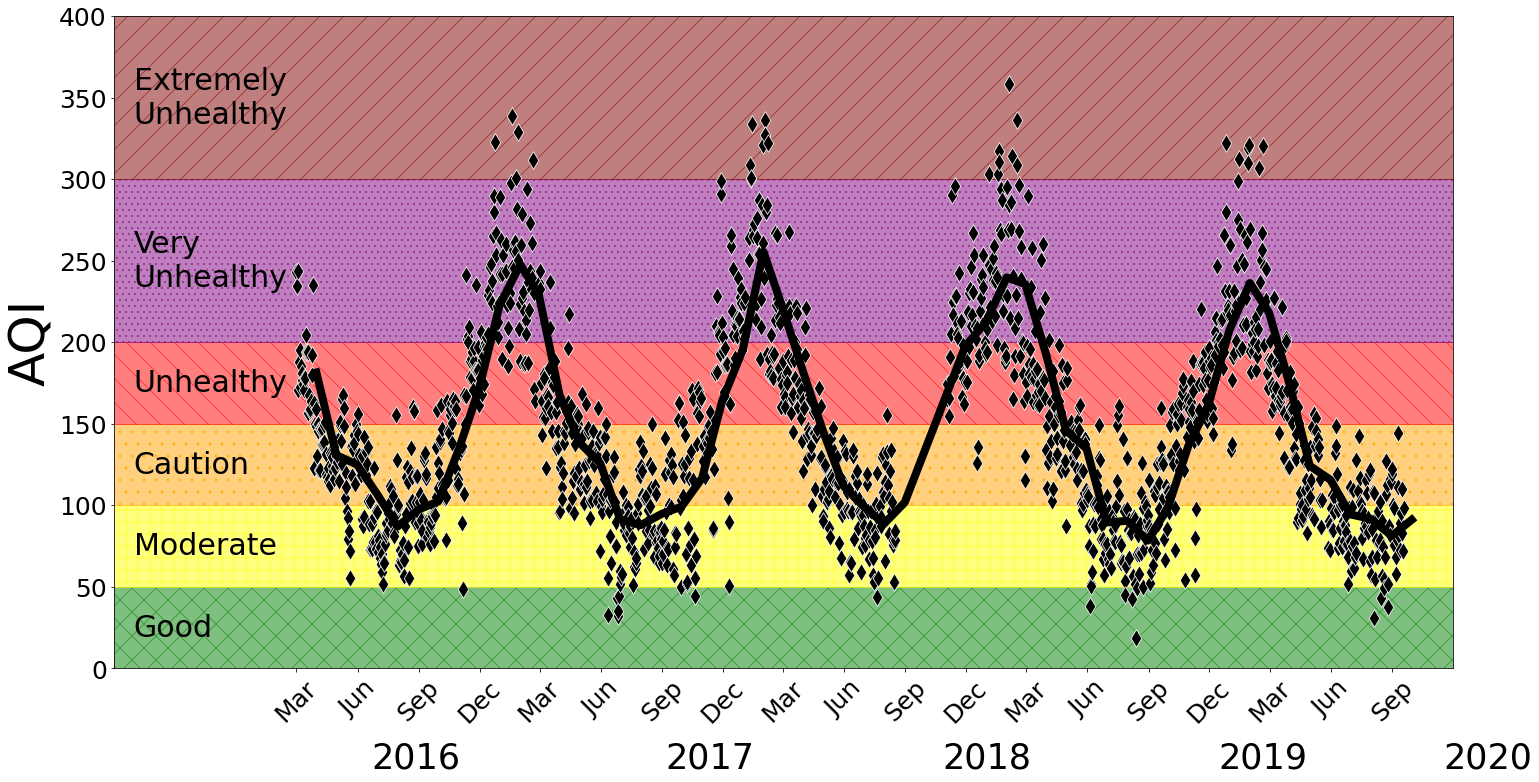

In [14]:
fig, ax = plt.subplots(figsize=(24,12))
trans = 0.5
xpoints = [datetime.strptime('2015-01-01', "%Y-%m-%d"), datetime.strptime('2020-12-01', "%Y-%m-%d")]
plt.fill_between(x = xpoints, y1 = 0, y2 = 50 , color = 'green', alpha = trans, hatch = 'x')
plt.fill_between(x = xpoints, y1 = 50, y2 = 100 , color = 'yellow', alpha = trans, hatch = '+')
plt.fill_between(x = xpoints, y1 = 100, y2 = 150 , color = 'orange', alpha = trans, hatch = '.')
plt.fill_between(x = xpoints, y1 = 150, y2 = 200 , color = 'red', alpha = trans, hatch = '\\')
plt.fill_between(x = xpoints, y1 = 200, y2 = 300 , color = 'purple', alpha = trans, hatch = '..')
plt.fill_between(x = xpoints, y1 = 300, y2 = 500 , color = 'maroon', alpha = trans, hatch = '/')

ax=sns.scatterplot(x=df_dayavg.index, y='AQImean', data = df_dayavg, color = 'k', s = 155, marker = 'd')#, #legend = False,
#sns.lineplot(x=df_dayavg.index,  y='AQImean', data = df_monthavg[df_monthavg['Date']<'2018-08-17'], color = 'k', lw = 8)#, #legend = False,
#sns.lineplot(x=df_dayavg.index,  y='AQImean', data = df_monthavg[df_monthavg['Date']>'2018-11-01'], color = 'k', lw = 8)#, #legend = False,
sns.lineplot(x=df_monthavg.index,  y='AQImean', data = df_monthavg, color = 'k', lw = 8)#, #legend = False,
# df.AQI.resample('M').mean().plot(ax=ax)
# df.AQI.resample('D').mean().plot(kind='scatter', ax=ax)

textsize = 35
years = ['2016', '2017', '2018', '2019', '2020']
axis_positions = [0.3, 0.47, 0.63, 0.79, 0.92]
for xpos, year in zip(axis_positions, years):
    plt.figtext(xpos, 0.01, year, ha = 'center', fontsize = textsize)
    
quality_categories = ['Good', 'Moderate', 'Caution', 'Unhealthy', 'Very\nUnhealthy', 'Extremely\nUnhealthy']
y_positions = [25, 75, 125, 175, 250, 350]
textsize = 30
textstartdate = datetime.strptime('2015-07-01', "%Y-%m-%d")
for y_pos, category in zip(y_positions, quality_categories):
    plt.text(textstartdate, y_pos, category, va = 'center', fontsize = textsize)
    
plt.xticks([*map(lambda x: datetime.strptime(x, "%Y-%m"), ['2016-03', '2016-06', '2016-09', '2016-12', '2017-03', '2017-06', '2017-09', 
             '2017-12','2018-03', '2018-06', '2018-09', '2018-12', '2019-03', '2019-06', 
             '2019-09', '2019-12', '2020-03', '2020-06', '2020-09'])], rotation = 45, fontsize = 25)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.yticks(fontsize = 25)
plt.ylim(0,400)
plt.xlim(datetime.strptime('2015-06-01', "%Y-%m-%d"), datetime.strptime('2020-12-01', "%Y-%m-%d"))
plt.ylabel('AQI', fontsize =50)
plt.xlabel('')

plt.savefig('../report/AQImean.png', bbox_inches='tight')

<h2> Time of day variations </h2>

This section explores how the air quality varies over the day. Since there is a strong link between air quality, air movement and temperatures (dictated by the physics of gases and variations of pressure with temperature) and there is clearly seasonal variations in temperatures and daylight hours we need to consider the seasonal time of year too in this section. 

With this in mind I have created a heatmap of the AQI values as function of hour of the day and month of the year:

In [15]:
#  Create custom colour bar to match the standard AQI categories colour scheme

norm = mpl.colors.Normalize(-1,1)
aqicolors = [[0, 'green'], [55/350, 'yellow'], [75/350, 'yellow'], [105/350, 'orange'], [125/350, 'orange'], 
             [155/350, 'red'], [175/350, 'red'],[205/350, 'purple'], [275/350, 'purple'],[1, 'maroon']]
aqicmap = mpl.colors.LinearSegmentedColormap.from_list("", aqicolors)

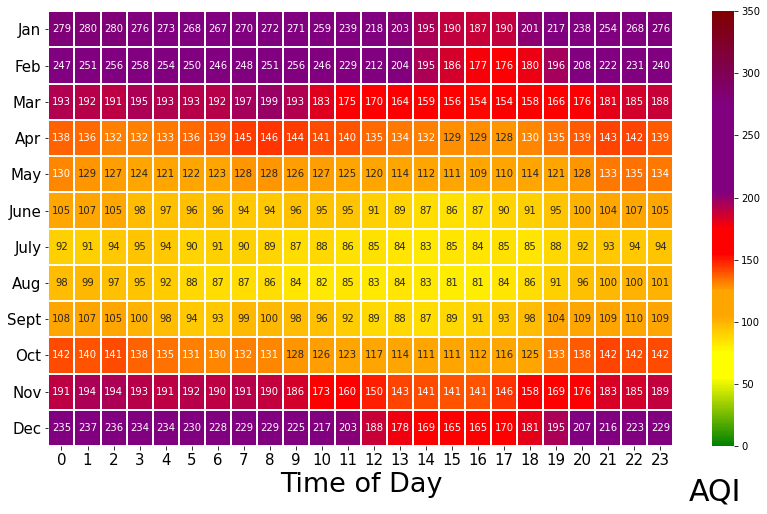

In [16]:
plt.figure(figsize=(14,8))
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
seasonaltable = df.pivot_table(values='AQI',index='Month',columns='Hour')
sns.heatmap(seasonaltable, cmap=aqicmap,linecolor='white',
            linewidths=1, yticklabels = months, vmin = 0, vmax = 350, annot = True, fmt = '.0f')
plt.ylabel('')
plt.xlabel('Time of Day', fontsize = 27)
plt.yticks(rotation = 0, fontsize = 15)
plt.xticks(fontsize=15)
plt.figtext(0.76,0.03,'AQI', fontsize = 30)
plt.savefig('../report/Heatmap_AQIcols.png', bbox_inches='tight')
plt.show()

Clearly there is variation of the air quality with respect to time of day. Counter-intuitively the air quality is better during the daylight hours of apprxoimately 10 AM to 6 PM despite increased traffic on the roads at this time. This is due to meterologoical effects whereby the hotter it is the more effectively pollutants can be dispersed into the upper atmosphere. 

The seasonal variation shown previously is also clear in this plot. The (western) summer months of June to September, which is monsoon season here, has the best air quality. The winter months generally have the worst air quality and, because at this time of year their are the largest swings in temperature between day and night, we see the largest variations in AQI across a typical day too. 

In [17]:
df['Weekday'] = df.index.day_name()

<h2> Daily variations</h2>
This suggests there is a moderate improvement in air quality on weekends, particualrly on Saturdays, but it is subtle.  

(50.0, 250.0)

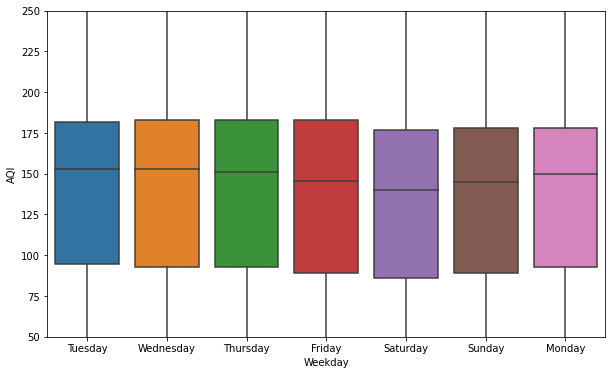

In [18]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
sns.boxplot(data=df, x='Weekday', y='AQI')
plt.ylim(50,250)

<h2>Hourly Variation</h2>
We see here that the air quality varies with time of day. The air quality is clearly improved between the hours of 11 AM and 7 PM with the lowest AQI valyes in the mid-afternoon at 3 -- 4 PM.

(50.0, 250.0)

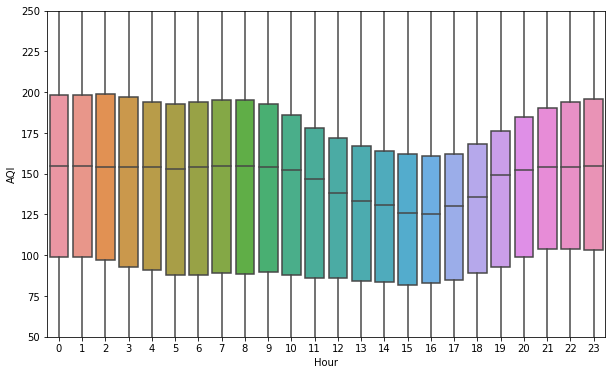

In [19]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
sns.boxplot(data=df, x='Hour', y='AQI')
plt.ylim(50,250)

<h2> Annual variations</h2>
The annual differences are difficult to compare as 2016, 2018 and 2020 are incomplete. 

In the case of 2016 we are missing the first few months of the year, where AQI is usually at its worst, which could account for the lower on average AQI for that annum. For 2020 we are missing the final few months (as not happened yet; AQI in these months worsens) and for 2018 we are missing data from August to November (which is a mix of low AQI, getting higher). It is notable that 2018 AQI is the worst given that data is missing for months which are typically low, which suggests 2018 was indeed a worse year. 

Comparison between 2019 and 2017 (the two complete years), shows little difference. 


(0.0, 350.0)

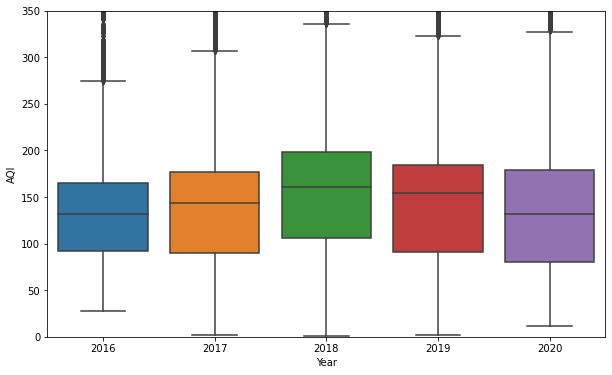

In [20]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
sns.boxplot(data=df, x='Year', y='AQI')
plt.ylim(0,350)

<h2> Monthly seasonal variation:</h2>
There is clearly seasonal variation with the typical AQI values varying substantially by month of the year. The air quality is worse during the winter months (particularly Dec to Feb). The air quality is at its best during the monsoon months between June and September. 

(0.0, 350.0)

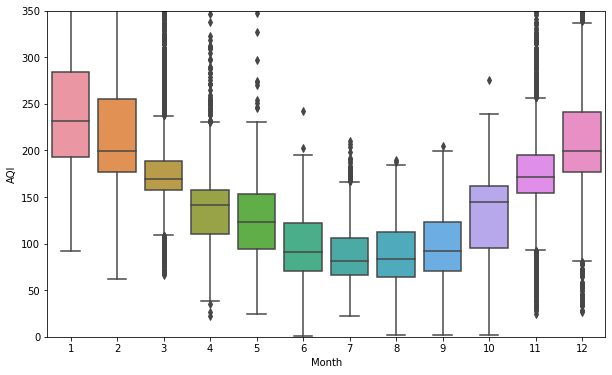

In [21]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
sns.boxplot(data=df, x='Month', y='AQI')
plt.ylim(0,350)

<h2> Monthly variation by year:</h2>
 

(0.0, 13.0)

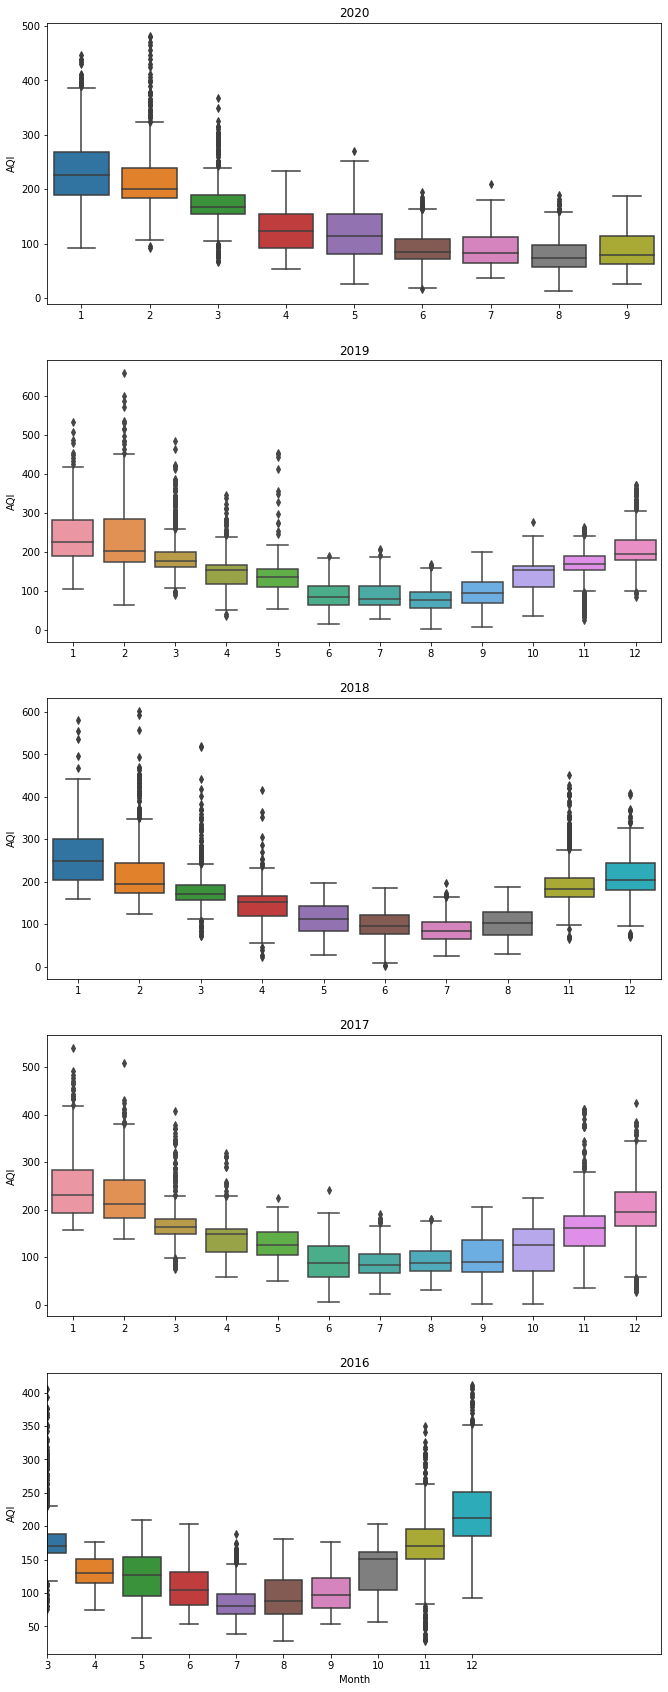

In [22]:
fig, axes = plt.subplots(5, 1, figsize=(11, 30))
for year, ax in zip([2020, 2019, 2018, 2017, 2016], axes):
    sns.boxplot(data=df[str(year)], x='Month', y='AQI', ax=ax)
    ax.set_ylabel('AQI')
    ax.set_title(year)
    #ax.set_xlim(0,13)
    if ax != axes[-1]:
        ax.set_xlabel('')
plt.xlim(0,13)



<h2>Smoothing:</h2> Days, Weeks, Months, Quartley and Annual

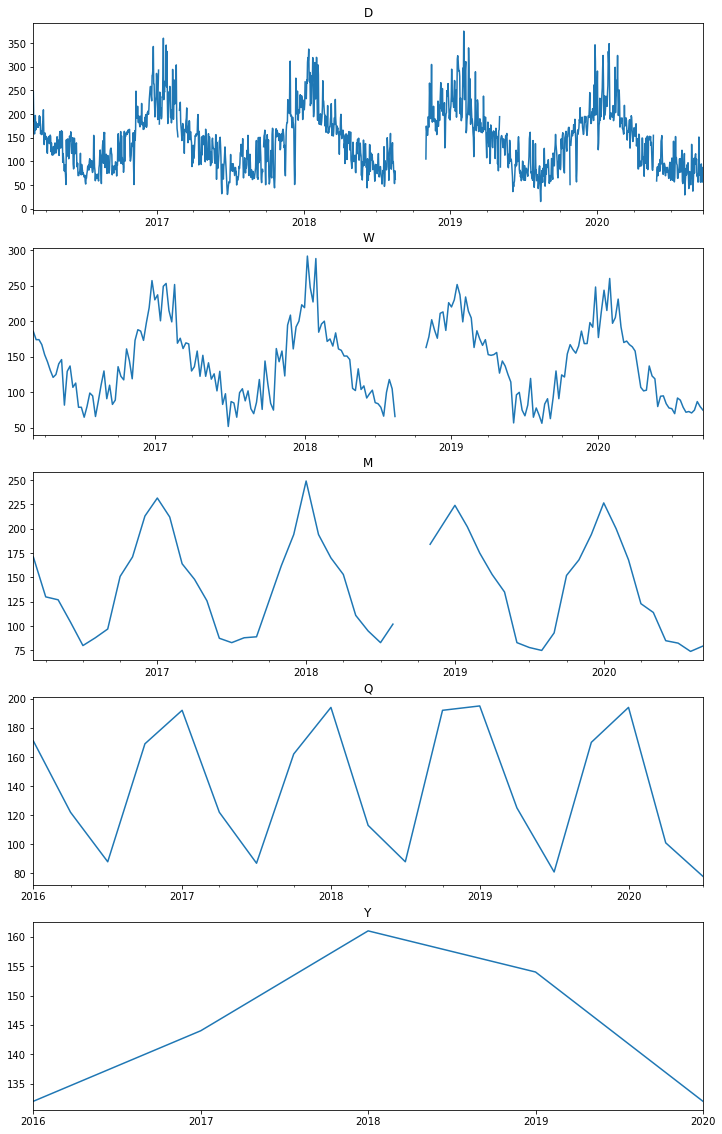

In [23]:
fig, axes = plt.subplots(5, 1, figsize=(12, 20))
for period, ax in zip(['D', 'W', 'M', 'Q', 'Y'], axes):
    df.AQI.resample(period).median().plot(ax=ax)
    ax.set_title(period)
    ax.set_xlabel('')



<h2> Annual trends?</h2>
Below we show the per cent change between the monthy averaged values and that of the previous annum. This shows little variation (< +/- 0.5 per cent) between the years suggesting a consistent AQI.

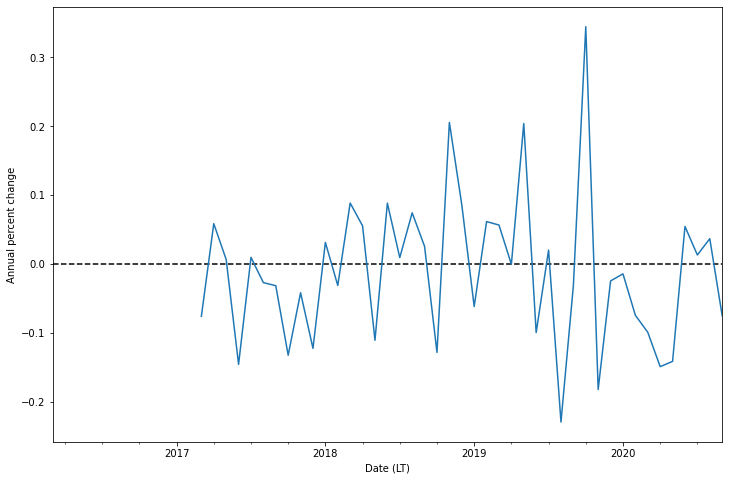

In [24]:
fig, axes = plt.subplots(1, 1, figsize=(12, 8))
df.AQI.resample('M').mean().pct_change(periods=12).plot()
plt.ylabel('Annual percent change')
plt.hlines(y=0, xmin=df.index.min(), xmax=df.index.max(), linestyles='dashed')

Comparing the daily averaged values with that of the same day of the previous year below also shows little change, with most variations < 1 per cent. There are a handful of values between 2 and 3 per cent, which are notably all positive changes, meaning on those days the air quality was worse than on the same day last year. However more significantly, there is no general trend with values consistently about zero, which suggests little year-on-year improvemennt or decline in air quality.

Text(0, 0.5, 'Year-on-year daily percent change')

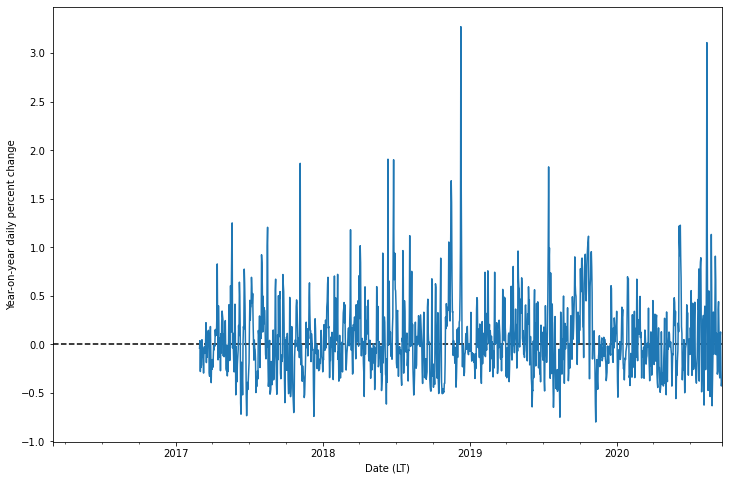

In [25]:
fig, axes = plt.subplots(1, 1, figsize=(12, 8))
df.AQI.resample('D').mean().pct_change(periods=365).plot()
plt.hlines(y=0, xmin=df.index.min(), xmax=df.index.max(), linestyles='dashed')
plt.ylabel('Year-on-year daily percent change')

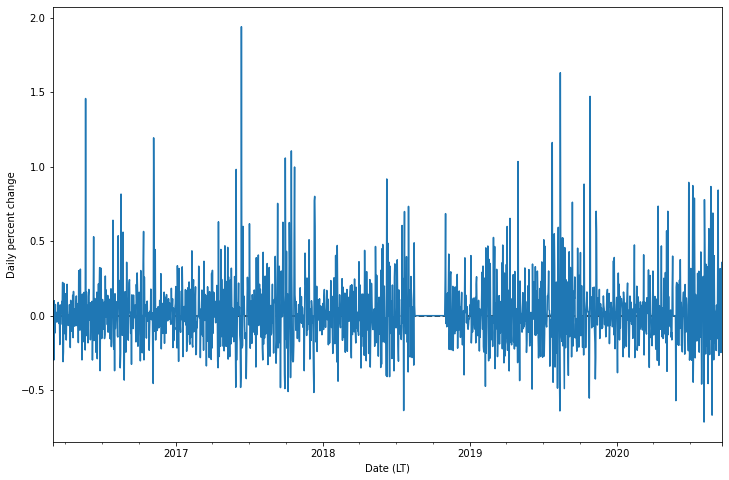

In [26]:
fig, axes = plt.subplots(1, 1, figsize=(12, 8))
df.AQI.resample('D').mean().pct_change(periods=1).plot()
plt.ylabel('Daily percent change')
plt.hlines(y=0, xmin=df.index.min(), xmax=df.index.max(), linestyles='dashed')

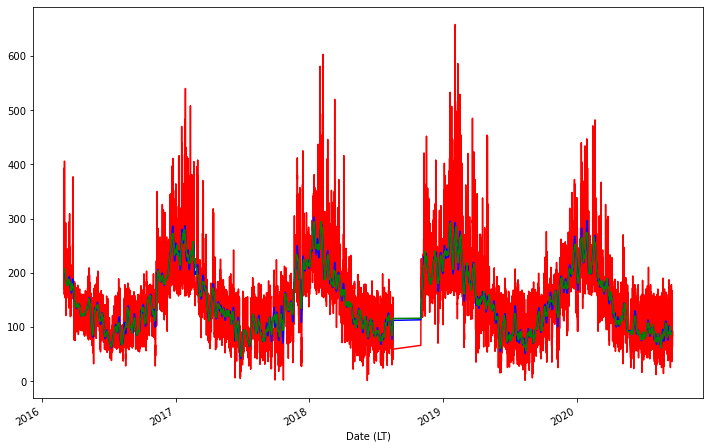

In [27]:
fig, axes = plt.subplots(1, 1, figsize=(12, 8))
df.AQI.plot(color='red', ax=axes)
df.AQI.rolling(window=24*7, center=True, win_type="triang").mean().plot(color='blue', ax=axes)
df.AQI.rolling(window=24*7, center=True).mean().plot(color='green', ax=axes)

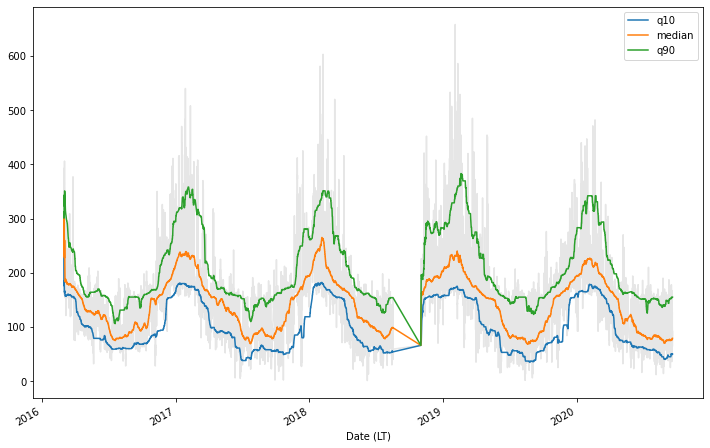

In [28]:
fig, axes = plt.subplots(1, 1, figsize=(12, 8))
df.AQI.plot(color='0.9', ax=axes)
rolling = df.AQI.rolling('30D')
q10 = rolling.quantile(0.1).to_frame('q10')
q90 = rolling.quantile(0.9).to_frame('q90')
median = rolling.median().to_frame('median')
pd.concat([q10, median, q90], axis=1).plot(ax=axes)
